# KNN, рак и спам
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][MS][ML][HW01] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from typing import NoReturn, Tuple, List

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [2]:
def read_cancer_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к cancer датасету.

    Returns
    -------
    X : np.array
        Матрица признаков опухолей.
    y : np.array
        Вектор бинарных меток, 1 соответствует доброкачественной опухоли (M), 
        0 --- злокачественной (B).

    
    """
    df = pd.read_csv(path_to_csv).sample(frac = 1)    # перемешиваем
    df.loc[df['label']=='M', 'label'] = 1
    df.loc[df['label']=='B', 'label'] = 0

    X = df.drop('label', axis = 1)
    y = df['label']
    return np.array(X), np.array(y)


def read_spam_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к spam датасету.

    Returns
    -------
    X : np.array
        Матрица признаков сообщений.
    y : np.array
        Вектор бинарных меток, 
        1 если сообщение содержит спам, 0 если не содержит.
    
    """
    df = pd.read_csv(path_to_csv).sample(frac = 1)    # перемешиваем
    X = df.drop('label', axis = 1)
    y = df['label']
    return np.array(X), np.array(y)


### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [3]:
def train_test_split(X: np.array, y: np.array, ratio: float
                     ) -> Tuple[np.array, np.array, np.array, np.array]:
    """

    Parameters
    ----------
    X : np.array
        Матрица признаков.
    y : np.array
        Вектор меток.
    ratio : float
        Коэффициент разделения.

    Returns
    -------
    X_train : np.array
        Матрица признаков для train выборки.
    y_train : np.array
        Вектор меток для train выборки.
    X_test : np.array
        Матрица признаков для test выборки.
    y_test : np.array
        Вектор меток для test выборки.

    """
    # у нас данные уже перемешаны, просто разделим их в нужном отношении
    split_n = int(np.around(ratio * X.shape[0]))
    X_train = X[: split_n]
    y_train = y[: split_n]
    X_test = X[split_n :]
    y_test = y[split_n :]
    
    return X_train, y_train, X_test, y_test
    

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [4]:
def get_precision_recall_accuracy(y_pred: np.array, y_true: np.array
                                  ) -> Tuple[np.array, np.array, float]:
    """

    Parameters
    ----------
    y_pred : np.array
        Вектор классов, предсказанных моделью.
    y_true : np.array
        Вектор истинных классов.

    Returns
    -------
    precision : np.array
        Вектор с precision для каждого класса.
    recall : np.array
        Вектор с recall для каждого класса.
    accuracy : float
        Значение метрики accuracy (одно для всех классов).

    """
    true = sum(y_pred == y_true) #все правильные делить на все неправильные - accuracy
    all = y_pred.shape[0]
    accuracy = true/all
    
    precision, recall = np. array([]), np. array([]) 
    #для того, чтобы посчитать метрики для каждого класса, нам нужно 
    #посчитать для них TP, FN, FP
    #еще надо понять, для чего считать, то есть нам нужен массив с классами
    classes = np.unique(y_true)
    for item in classes:
      TP = sum((y_pred == item) * (y_true == item))
      FP = sum((y_pred == item) * (y_true != item))
      FN = sum((y_pred != item) * (y_true == item))
      precision = np.append(precision, [TP/(TP+FP)])
      recall = np.append(recall, [TP/(TP+FN)])
    return precision, recall, accuracy



    


Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [5]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [6]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [7]:
class Node:
    def __init__(self, value=None, axis=None, data=None):
        self.value = value
        self.axis = axis
        self.data = data
        self.left = None
        self.right = None

    def single_query(self, root, point, k):

        if root.left is None and root.right is None:

            neigh_dist = np.sqrt(np.sum((root.data[:, 1:] - point) ** 2, axis=1))
            neigh_index = np.argsort(neigh_dist)
            index = root.data[neigh_index][:k]
            return neigh_dist[neigh_index], index

        else:
            axis = root.axis - 1
            if root.value > point[axis]:
                neigh_dist, index = self.single_query(root.left, point, k)
                opposite = root.right

            else:
                neigh_dist, index = self.single_query(root.right, point, k)
                opposite = root.left

            if neigh_dist[-1] >= np.sqrt(np.sum(point[axis] - root.value) ** 2) or len(index) < k:
                opposite_dist, opposite_index = self.single_query(opposite, point, k)
                return merge(opposite_index, opposite_dist, index, neigh_dist, k)

            return neigh_dist, index

def merge(opposite_ind, opposite_dist, index, neigh_dist, k):
    i = j = 0
    index_merged = []
    dist_merged = []
    while (i < len(opposite_ind)) and (j < len(index)) and (i + j < k):
        if opposite_dist[i] <= neigh_dist[j]:
            index_merged.append(opposite_ind[i])
            dist_merged.append(opposite_dist[i])
            i += 1
        else:
            index_merged.append(index[j])
            dist_merged.append(neigh_dist[j])
            j += 1
    delta = k - i - j
    index_merged.extend(opposite_ind[i: i + delta])
    dist_merged.extend(opposite_dist[i: i + delta])
    index_merged.extend(index[j: j + delta])
    dist_merged.extend(neigh_dist[j: j + delta])
    return dist_merged, index_merged


In [8]:
class KDTree:
    def __init__(self, X, leaf_size=40):
        self.X = np.hstack([np.arange(X.shape[0]).reshape(-1, 1), X])
        self.dim = X[0].size

        self.leaf_size = leaf_size
        self.root = self.build_tree(self.X, depth=0)

    def build_tree(self, X, depth=0):

        axis = (depth % self.dim) + 1
        median = np.median(X[:, axis])
        left, right = X[X[:, axis] < median], X[X[:, axis] >= median]

        if left.shape[0] < self.leaf_size or right.shape[0] < self.leaf_size:
            return Node(data=X)

        root = Node(value=median, axis=axis)

        root.left = self.build_tree(left, depth + 1)
        root.right = self.build_tree(right, depth + 1)

        return root

    def index_extraction(self, point, k=4):
        one_point_ans = []
        point_neigh = self.root.single_query(self.root, point, k=k)
        for index in point_neigh[1]:
            one_point_ans.append(int(index[0]))
        return one_point_ans

    def query(self, X, k=4):
        res = []
        for point in X:
            ans = self.index_extraction(point, k=k)
            res.append(ans)
        return res


Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [9]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
# predicted = tree.query(X_test, k=4, return_distance=False)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [10]:
# Сделаем класс, который делает нормировку данных

class Scaler:
    def __init__(self):
        self.mean = None
        self.std = None
    
    def train(self, X):    # узнаем mean и std на X_train
        self.mean = X.mean(axis=0)
        self.std = X.std(axis=0)
        return self

    def scale(self, X):
        X = (X - self.mean) / self.std
        return X
    
    def train_scale(self, X):    # совместим train и scale для удобства
        X = self.train(X).scale(X)
        return X

In [12]:
class KNearest:
    def __init__(self, n_neighbors: int = 5, leaf_size: int = 40):
        """
        Parameters
        ----------
        n_neighbors : int
            Число соседей, по которым предсказывается класс.
        leaf_size : int
            Минимальный размер листа в KD-дереве.
        """
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size
        self.tree = None
        self.labels = None

    def fit(self, X: np.array, y: np.array) -> NoReturn:
        """
        Parameters
        ----------
        X : np.array
            Набор точек, по которым строится классификатор.
        y : np.array
            Метки точек, по которым строится классификатор.
        """
        self.tree = KDTree(X, self.leaf_size)
        self.labels = y

    def one_proba(self, point):
        labels = np.sum(self.labels[point]) / self.n_neighbors
        return np.array([1 - labels, labels])

    def predict_proba(self, X: np.array):
        neigh = self.tree.query(X, k=self.n_neighbors)
        prob = []
        for point in neigh:
            curr_prob = self.one_proba(point)
            prob.append(curr_prob)
        return prob

    def predict(self, X: np.array) -> np.array:
        """
        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        Returns
        -------
        np.array
            Вектор предсказанных классов.
        """

        return np.argmax(self.predict_proba(X), axis=1)

Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

Воспользуемся классом Scaler

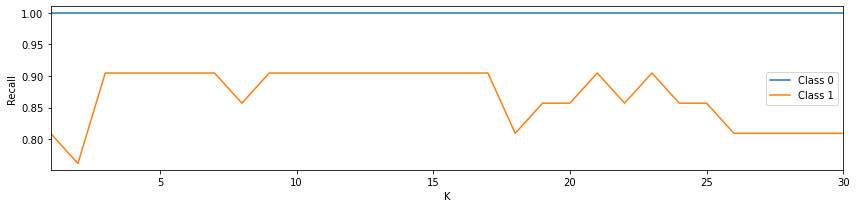

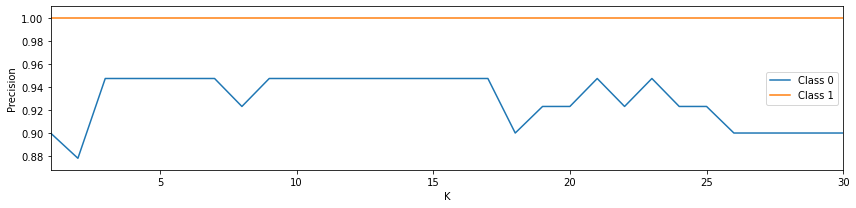

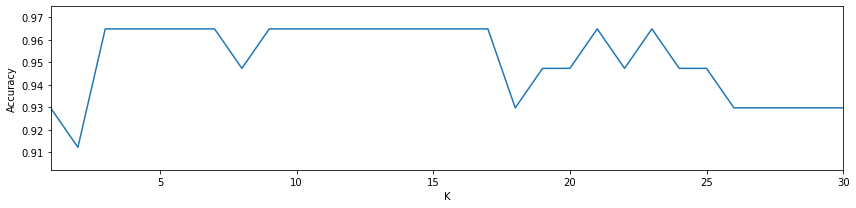

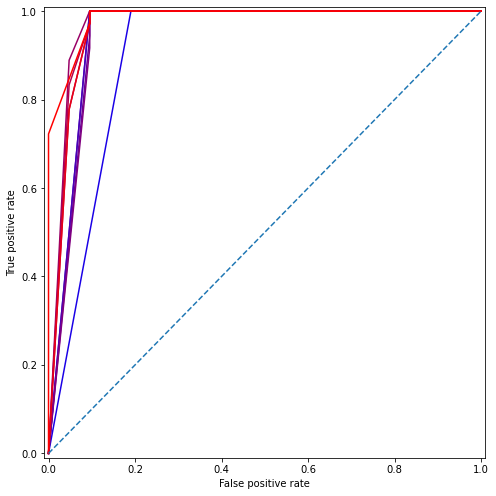

CPU times: user 2.19 s, sys: 40.3 ms, total: 2.23 s
Wall time: 2.53 s


In [13]:
%%time
scaler = Scaler()
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
X_train = scaler.train_scale(X_train)
X_test = scaler.scale(X_test)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

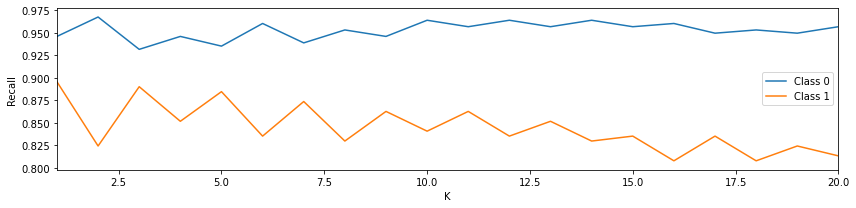

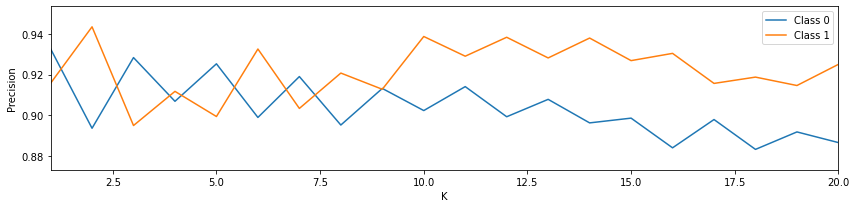

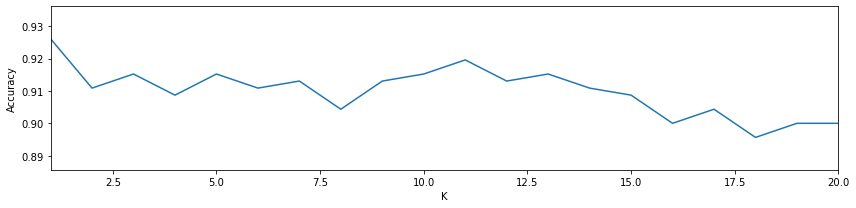

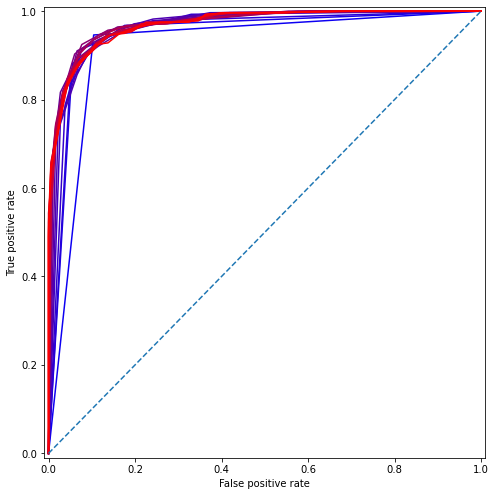

CPU times: user 42.3 s, sys: 43.5 ms, total: 42.4 s
Wall time: 42.5 s


In [14]:
%%time
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)

X_train = scaler.train_scale(X_train)
X_test = scaler.scale(X_test)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)